In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

2024-10-31 20:19:00.224410: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 各パス指定

In [2]:
dataset = 'model/keypoint_classifier/keypoint.csv'

# model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.keras' # added myself

# 分類数設定

In [3]:
NUM_CLASSES = 6

# 学習データ読み込み

In [4]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [5]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# モデル構築

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [8]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 20)                860       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 6)                 66        
                                                                 
Total params: 1,136
Trainable params: 1,136
Non-trainable params: 0
_________________________________________________________________


In [9]:
# モデルチェックポイントのコールバック
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# 早期打ち切り用コールバック
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [10]:
# モデルコンパイル
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# モデル訓練

In [11]:
# original epochs=1000
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
 1/12 [=>............................] - ETA: 9s - loss: 1.8106 - accuracy: 0.1797
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.keras
12/12 [==============================] - 1s 39ms/step - loss: 1.8219 - accuracy: 0.1919 - val_loss: 1.7781 - val_accuracy: 0.2407
Epoch 2/1000
 1/12 [=>............................] - ETA: 0s - loss: 1.7639 - accuracy: 0.2109
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.keras
12/12 [==============================] - 0s 8ms/step - loss: 1.7907 - accuracy: 0.2030 - val_loss: 1.7540 - val_accuracy: 0.2642
Epoch 3/1000
 1/12 [=>............................] - ETA: 0s - loss: 1.8269 - accuracy: 0.2422
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.keras
12/12 [==============================] - 0s 8ms/step - loss: 1.7888 - accuracy: 0.2324 - val_loss: 1.7330 - val_accuracy: 0.2994
Epoch 4/1000
 1/12 [=>............................] - ETA: 0s - loss: 1.7225 - accuracy: 0.26

In [12]:
# モデル評価
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

4/4 [==============================] - 0s 3ms/step - loss: 0.5536 - accuracy: 0.8591


In [13]:
# 保存したモデルのロード
model = tf.keras.models.load_model(model_save_path)

In [14]:
# 推論テスト
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 133ms/step
[3.0004248e-01 8.9244610e-03 1.0407675e-03 1.6463950e-02 3.1424450e-05
 6.7349696e-01]
5


In [15]:
# added myself
!pip install pandas seaborn


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


16/16 [==============================] - 0s 2ms/step


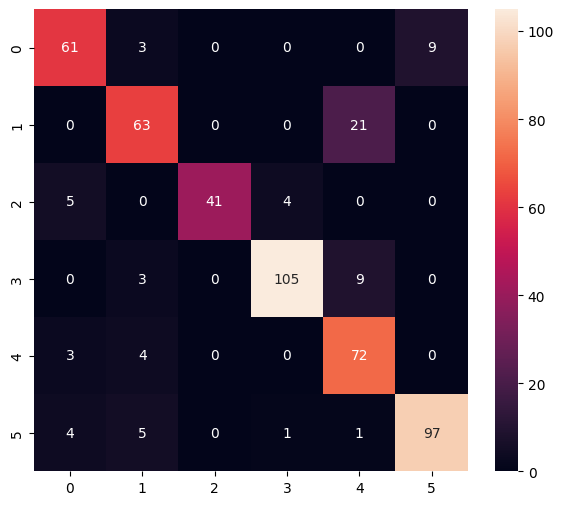

Classification Report
              precision    recall  f1-score   support

           0       0.84      0.84      0.84        73
           1       0.81      0.75      0.78        84
           2       1.00      0.82      0.90        50
           3       0.95      0.90      0.93       117
           4       0.70      0.91      0.79        79
           5       0.92      0.90      0.91       108

    accuracy                           0.86       511
   macro avg       0.87      0.85      0.86       511
weighted avg       0.87      0.86      0.86       511



In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# 混同行列

# Tensorflow-Lite用のモデルへ変換

In [17]:
# 推論専用のモデルとして保存
model.save(model_save_path, include_optimizer=False)

In [18]:
# added myself
# !pip install tensorflow

# import tensorflow as tf

In [19]:
import tensorflow as tf

# Load the model from the .keras file saved in your Jupyter notebook
model = tf.keras.models.load_model('model/keypoint_classifier/keypoint_classifier.keras')

# Define the path to save the TFLite model
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set up the TFLite converter with the original code
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

# Save the converted model
with open(tflite_save_path, 'wb') as f:
    f.write(tflite_quantized_model)

print()
print(f"TFLite model saved at: {tflite_save_path}")

INFO:tensorflow:Assets written to: /var/folders/21/gfkvnwns7l37tv63xv631fqw0000gn/T/tmp40f9cb7f/assets

TFLite model saved at: model/keypoint_classifier/keypoint_classifier.tflite


2024-10-31 20:20:46.114236: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2024-10-31 20:20:46.114663: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.


In [20]:
# Original code
# モデルを変換(量子化)
# tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# tflite_quantized_model = converter.convert()

# open(tflite_save_path, 'wb').write(tflite_quantized_model)

""" My code """

# # Load your model (adjust the path as necessary)
# model = tf.keras.models.load_model('model/keypoint_classifier/keypoint_classifier.keras')

# # Path to save the TFLite model
# tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# # Define a representative dataset generator with fewer samples
# def representative_data_gen():
#     for _ in range(10):  # Use fewer samples to reduce memory usage
#         yield [tf.random.normal([1] + list(model.input_shape[1:]))]

# # Set up the TFLite converter
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.target_spec.supported_types = [tf.int8]
# converter.representative_dataset = representative_data_gen

# # Convert the model
# tflite_model = converter.convert()

# # Save the converted model
# with open(tflite_save_path, 'wb') as f:
#     f.write(tflite_model)

# print(f"TFLite model saved at: {tflite_save_path}")


' My code '

# 推論テスト

In [21]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [22]:
# 入出力テンソルを取得
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [23]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [24]:
%%time
# 推論実施
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 1.44 ms, sys: 1.75 ms, total: 3.19 ms
Wall time: 4.07 ms


In [25]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[3.0004260e-01 8.9244675e-03 1.0407667e-03 1.6463947e-02 3.1424384e-05
 6.7349678e-01]
5
